In [115]:
!pip install nmrglue
!pip install peakutils

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 132
         Function evaluations: 246


<ipython-input-131-69b332a872b3>:67: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  area = simps(np.real(ph_corrected_spectrum[left:right]), frequencies[left:right])


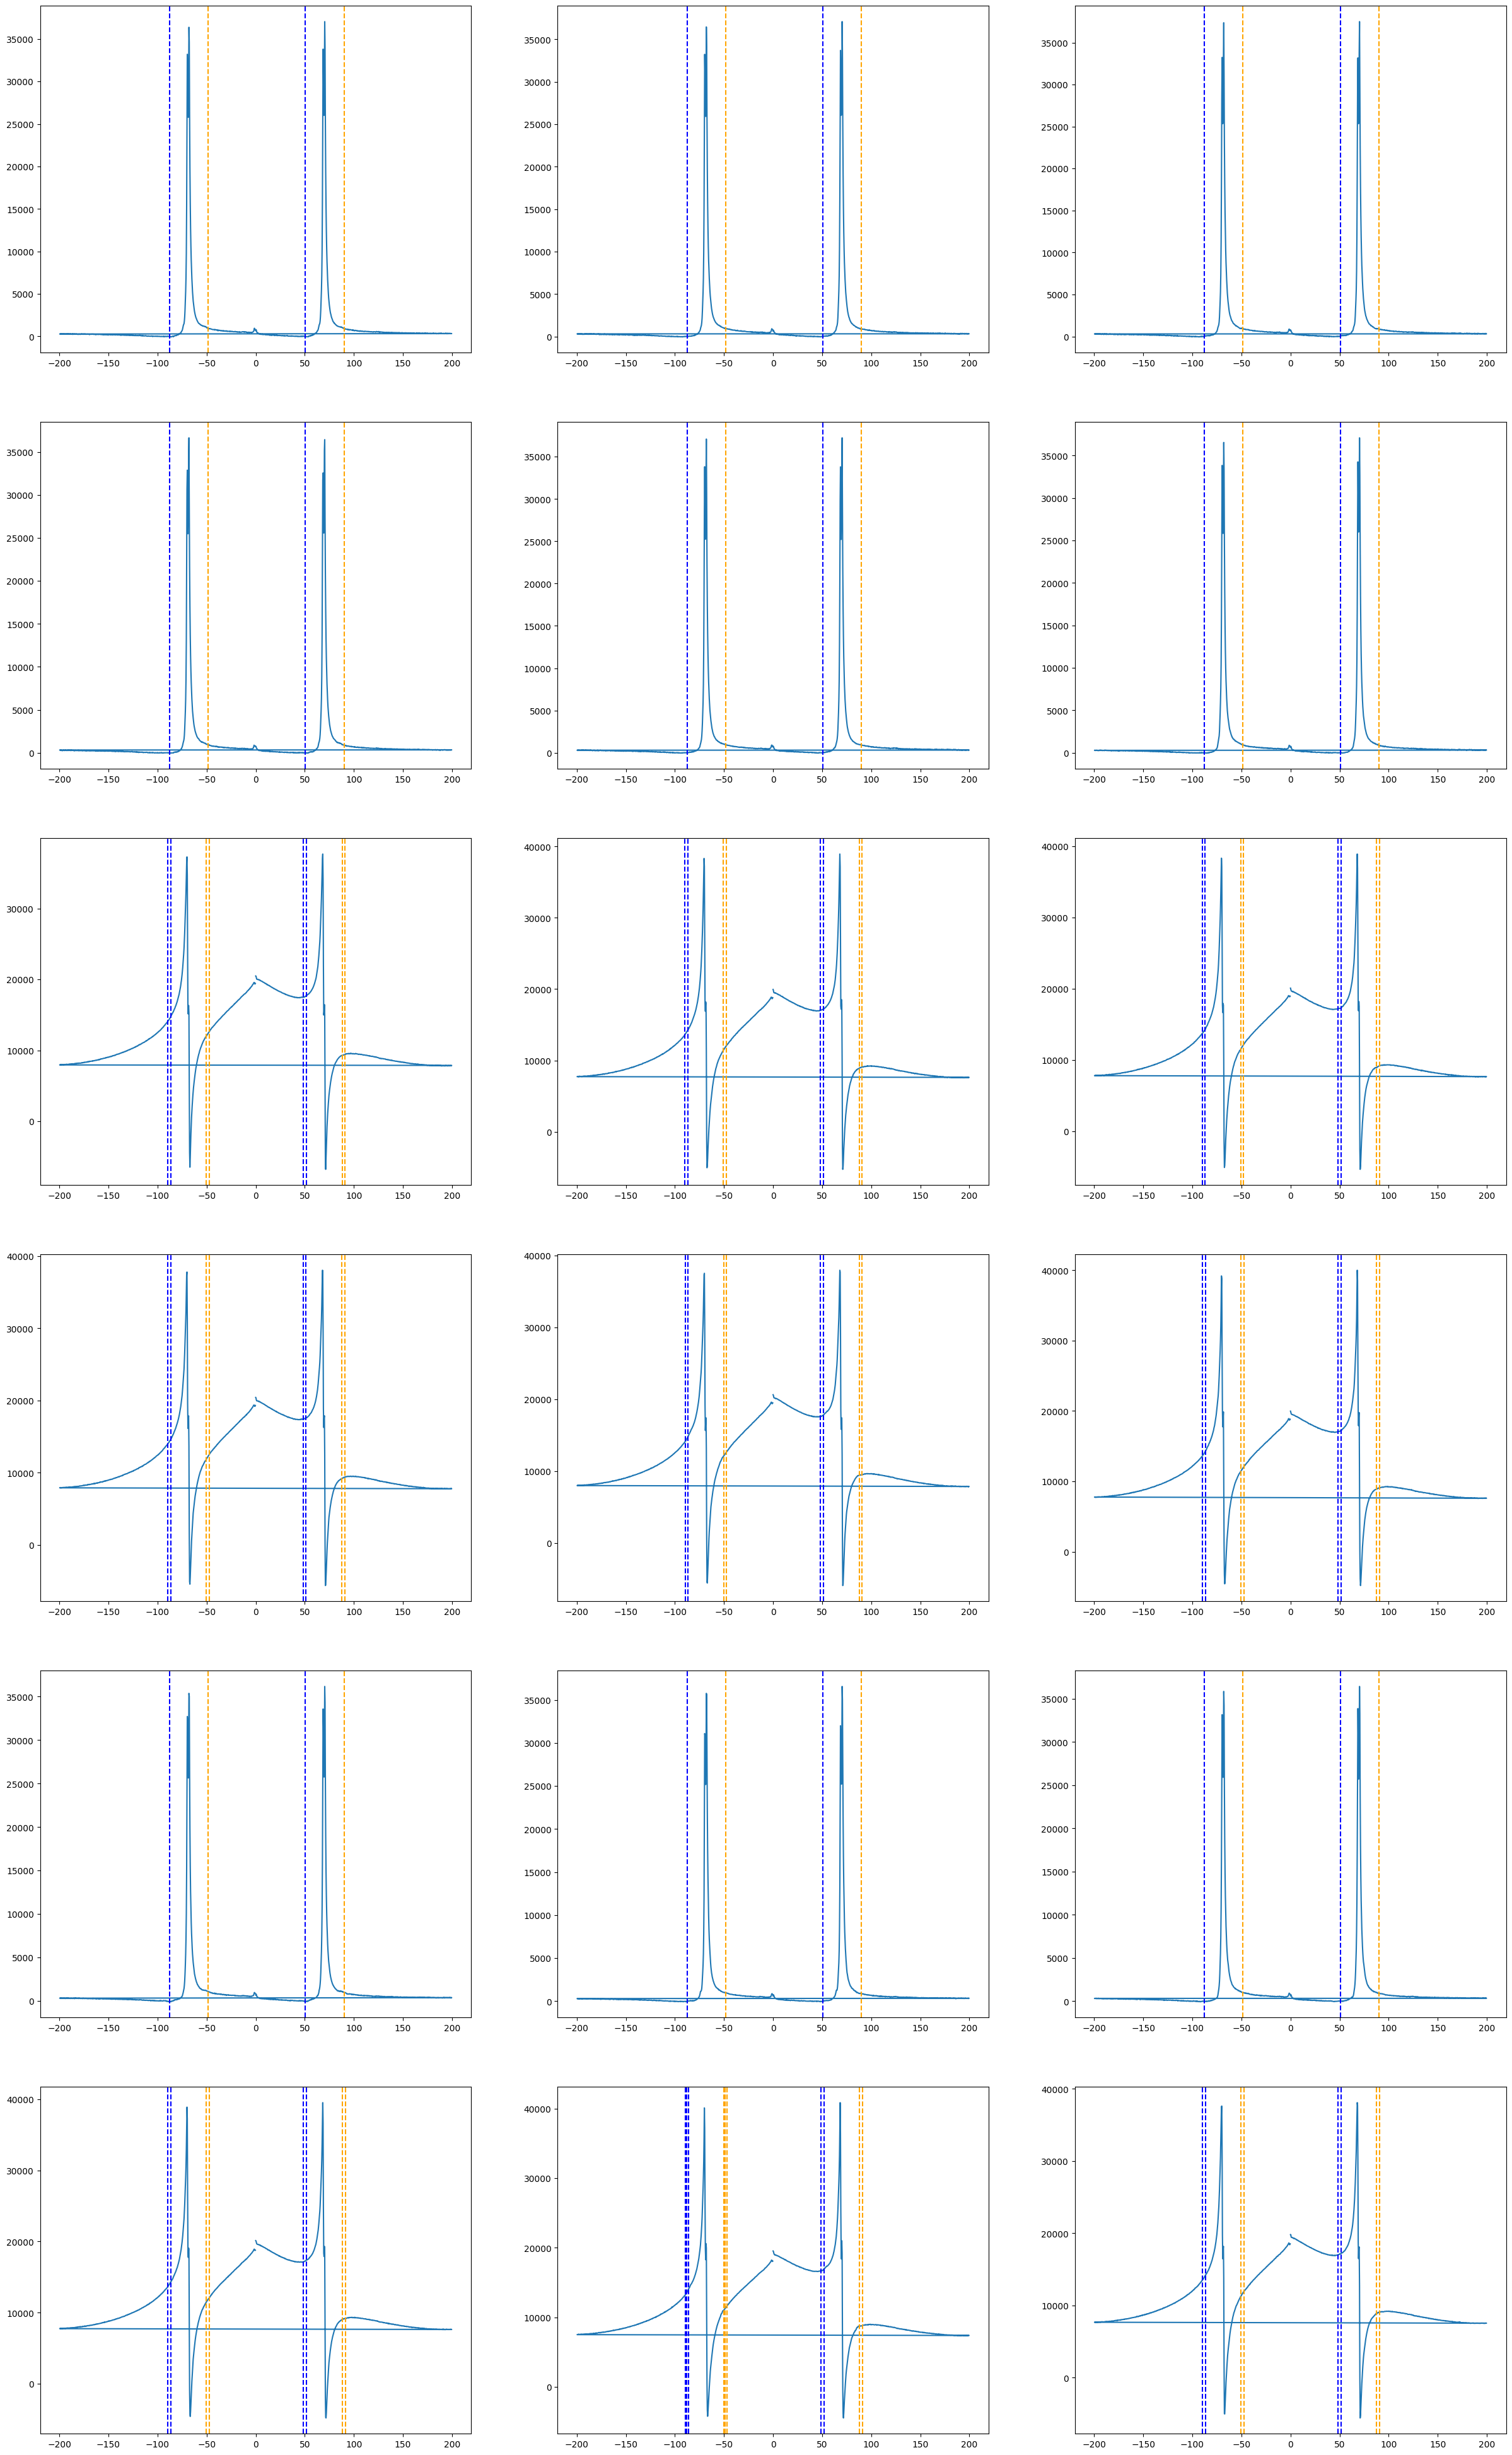

In [131]:
from sys import path_hooks
from scipy.integrate import simps
import pathlib as pth
import numpy as np
import nmrglue as ng
from matplotlib import pyplot as plt
import pandas as pd
from peakutils import baseline


def proper_phases(data):
    spectrum_unpr = np.fft.fft(data[0])
    spectrum, phases = ng.proc_autophase.autops(spectrum_unpr, 'acme', return_phases=True)
    return phases

def identity_operator_idx(data):
    max_vals = []
    for i in range(len(data)):
        spectrum_unpr = np.fft.fft(data[i])
        maxima = max(np.real(spectrum_unpr))
        max_vals.append(maxima)
    threshold = np.mean(maxima) / 100
    indices = [i for i, value in enumerate(max_vals) if value < threshold]
    return indices

tn = 'H' # Название исследуемого ядра

dic, data = ng.varian.read(r'test')
df = pd.read_csv('dict.csv')
filtered_df = df[df['nucleus'] == tn]
at = float(dic['procpar']['at']['values'][0])
peak_width = filtered_df['peak_width'].values[0]
center = filtered_df['center'].values[0]
region = filtered_df['borders'].values[0]

phases = proper_phases(data)
id_idx = identity_operator_idx(data)
n = len(data[0])
time = np.linspace(0, at, n)
dt = at / n

frequencies = np.fft.fftfreq(n, d=dt)
dnu = frequencies[1] - frequencies[0]
peak_idx_width = int(peak_width / dnu)
mask = (frequencies >= center-region) & (frequencies <= center+region)
frequencies = frequencies[mask]

integrated_areas = []
fig, axs = plt.subplots(6, 3, figsize=(30, 50))
axs = axs.flatten()
spectras = []
peaks = []

for idx in range(len(data)):
    if idx not in id_idx and idx != 0:
        spectrum = np.fft.fft(data[idx])[mask]
        ph_corrected_spectrum = np.real(spectrum * np.exp(1j * 2 * np.pi / 360 * (phases[0])))
        normalized_spectrum = ph_corrected_spectrum / max(ph_corrected_spectrum)
        bl = baseline(ph_corrected_spectrum, 2)
        corrected_spectrum = ph_corrected_spectrum - bl
        loc_peaks = ng.analysis.peakpick.pick(normalized_spectrum, 0.3, -0.3, table=True)
        iter = 1
        area_indices = []
        for peak in loc_peaks:
            left = int(peak[0] - peak_idx_width)
            right = int(peak[0] + peak_idx_width)
            area = simps(np.real(ph_corrected_spectrum[left:right]), frequencies[left:right])
            integrated_areas.append([{'index':idx + 1}, {'integral_num': iter}, {'area':area}])
            iter += 1
            area_indices.append([np.linspace(left, right, 2 * peak_idx_width + 2)])

        # numbers = list(i for i in range(len(ph_corrected_spectrum)))
        # nl = list(i - int(region) for i in range(peak_idx_width))
        peaks.append(loc_peaks)
        spectras.append(corrected_spectrum)

for idx in range(len(spectras)):
    axs[idx].plot(frequencies, spectras[idx])
    for i in range(len(peaks[idx])):
        s = int(peaks[idx][i][0] + peak_idx_width)
        p = int(peaks[idx][i][0] - peak_idx_width)
        axs[idx].axvline(x=frequencies[s], color='orange', linestyle='--')
        axs[idx].axvline(x=frequencies[p], color='blue', linestyle='--')
plt.show()

In [132]:
list(spectras[0])

[680.411062744969,
 811.0858412353285,
 723.3808712161959,
 560.3055027647016,
 482.2456174595194,
 447.7130420485113,
 369.2164068431814,
 357.0079360860932,
 392.3054511407022,
 321.6005405655196,
 307.1308776150064,
 299.90387713133805,
 311.1689226597622,
 283.402187601539,
 265.6855347632775,
 288.29103058050714,
 236.54006469597596,
 261.4109548521959,
 274.15112732185275,
 240.29490722056278,
 229.96515833646697,
 281.2822120173871,
 233.63116991285244,
 216.4304917134333,
 241.01385482353862,
 228.88996583865242,
 245.60011675168153,
 233.29388295947172,
 225.41305491591754,
 220.34219949588658,
 189.61119724570392,
 196.82416562509025,
 234.7465604991345,
 213.53480772598243,
 198.9356162330788,
 205.12899570983416,
 182.71717250086158,
 225.64506202537768,
 190.14752065949392,
 192.34723444073506,
 197.98442346124034,
 167.71994676058273,
 184.54971029896296,
 141.47737994995202,
 168.65548163637857,
 149.5293752965979,
 146.18069145775473,
 152.4750241273531,
 165.3718684785